In [1]:
#yahoo finance as data source
# !pip3 install yfinance
import yfinance as yf
from oauth2client.service_account import ServiceAccountCredentials
import gspread as gs
import gspread_dataframe as gd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

In [2]:
scope =["https://spreadsheets.google.com/feeds",'https://www.googleapis.com/auth/spreadsheets',
        "https://www.googleapis.com/auth/drive.file","https://www.googleapis.com/auth/drive"]

In [3]:
creds=ServiceAccountCredentials.from_json_keyfile_name(r"C:\Users\MAHESH DETHE\Downloads\GROUP PROJECT API KEY.json",scope)

In [4]:
client = gs.authorize(creds)

In [5]:
file = client.open("Final Template").sheet1

In [6]:
path = r"C:\Users\MAHESH DETHE\Downloads\MW-NIFTY-50-04-Nov-2022.csv"
nifty = pd.read_csv(path)
comp_data = nifty['SYMBOL \n'][1:].values.tolist()    #  list of Nifty 50 companies

In [7]:
# main = pd.DataFrame()
# for i in comp_data:
#     stock_symbol = i + '.NS'
#     data = yf.download(tickers = stock_symbol,period = '4y',interval = '1d' )
#     data['Name'] = i
#     main = pd.concat([main,data],axis = 0)
# main = main.reset_index()
# main = main.sort_values(['Name','Date'])
# main.to_csv('stock_price_data')

In [8]:
main = pd.read_csv(r"C:\Users\MAHESH DETHE\Downloads\stock_price_data")

In [9]:
main.columns

Index(['Unnamed: 0', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume', 'Name'],
      dtype='object')

In [10]:
data = main[main['Name'] == 'TCS']             # data for training the model

In [11]:
opn = data[['Open']]

<AxesSubplot:>

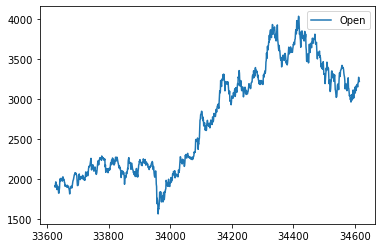

In [12]:
opn.plot()

In [13]:
df = opn.values

In [14]:
from sklearn.preprocessing import MinMaxScaler
# Using MinMaxScaler for normalizing data 
mm = MinMaxScaler(feature_range=(0,1))
scaled_df = mm.fit_transform(np.array(df).reshape(-1,1))  #df is list of open stock prices of the company

In [15]:
#Defining test and train data sizes
train_size = int(len(scaled_df)*0.70)
test_size = len(scaled_df) - train_size    

In [16]:
#Splitting data between train and test
ds_train, ds_test = scaled_df[0:train_size,:], scaled_df[train_size:len(scaled_df),:1]     
# we are splitting it without sklearn cause it will take random dates but we want sequential records .

In [17]:
# Creating dataset in time series for LSTM model 
def create_df(dataset,k):
    Xtrain, Ytrain = [] , []
    for i in range(len(dataset)-k-1):
        new_df = dataset[i:(i+k), 0]
        Xtrain.append(new_df)
        Ytrain.append(dataset[i + k, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [18]:
# Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_df(ds_train,time_stamp)
X_test, y_test = create_df(ds_test,time_stamp)

In [19]:
# Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
# importing LSTM 
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [21]:
# Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [22]:
#Training model with adam optimizer and mean squared error loss function
model.compile( loss = 'mean_squared_error', optimizer = 'adam' )
model.fit(X_train,y_train,validation_data = (X_test , y_test), epochs = 100, batch_size = 64 )

Epoch 1/100
10/10 [==============================] - 10s 356ms/step - loss: 0.0727 - val_loss: 0.0113
Epoch 2/100
10/10 [==============================] - 2s 192ms/step - loss: 0.0126 - val_loss: 0.0314
Epoch 3/100
10/10 [==============================] - 2s 253ms/step - loss: 0.0060 - val_loss: 0.0025
Epoch 4/100
10/10 [==============================] - 3s 263ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 5/100
10/10 [==============================] - 2s 249ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 6/100
10/10 [==============================] - 2s 234ms/step - loss: 0.0023 - val_loss: 0.0058
Epoch 7/100
10/10 [==============================] - 2s 233ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 8/100
10/10 [==============================] - 2s 252ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 9/100
10/10 [==============================] - 3s 252ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 10/100
10/10 [==============================] - 4s 386ms/step - loss: 0.0019 - val_l

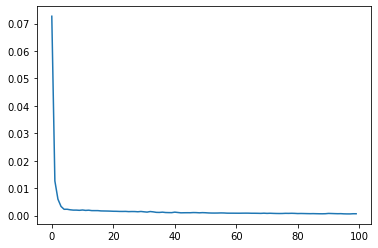

In [23]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [24]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

7/7 [==============================] - 0s 43ms/step


In [25]:
#Inverse transform to get actual value
train_predict = mm.inverse_transform(train_predict)
test_predict = mm.inverse_transform(test_predict)

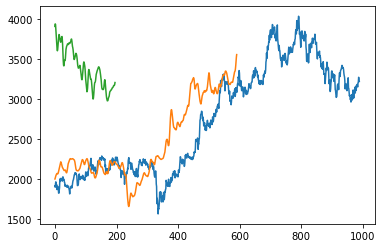

In [26]:
#Comparing using visuals
plt.plot(mm.inverse_transform(scaled_df))
plt.plot(train_predict)
plt.plot(test_predict)

In [27]:
test = np.vstack((train_predict,test_predict))

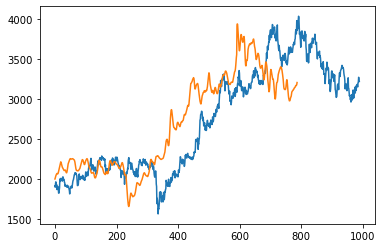

In [28]:
# Combining the predited data to create uniform data visualization
plt.plot(mm.inverse_transform(scaled_df))
plt.plot(test)

In [64]:
# function for automating gsheet
def main_fn():
    name = file.cell(1,4).value     #checking company name
    # for buying date
    buy_date = file.cell(3,4).value.split('-')  #checking buying date
    
    y_buy  = [int(i) for i in buy_date]
    b_date = datetime.date(y_buy[0],y_buy[1],y_buy[2])
    
    #if date is in the data,take the same stock price as in the data else predict
    
    sub = main[main['Name'] == name]
    x = file.cell(3,4).value
    if x in main['Date'].values:
        val_x = sub.loc[sub['Date'] == x,'Open'].values[0]
        file.update_cell(7,4,val_x)
    elif b_date >= datetime.date(2022,11,5):
        diff = (b_date - datetime.date(2022,11,4)).days
        #predict
        #Getting the last 100 days records
        m = sub['Open'].tail(100)
        fut_inp = sub['Open'].tail(100).values.reshape(-1,1).reshape(1,-1)
        tmp_inp = list(fut_inp)
        #Creating list of the last 100 data
        tmp_inp = tmp_inp[0].tolist()
        list_output=[]
        n_steps=100
        i=0
        while(i < diff ):
            if(len(tmp_inp)>100):
                fut_inp = np.array(tmp_inp[1:])
                fut_inp=fut_inp.reshape(1,-1)
                fut_inp = fut_inp.reshape((1, n_steps, 1))
                y_pred = model.predict(fut_inp, verbose=0)
                tmp_inp.extend(y_pred[0].tolist())
                tmp_inp = tmp_inp[1:]
                list_output.extend(y_pred.tolist())
                i = i + 1
            else:
                fut_inp = fut_inp.reshape((1, n_steps,1))
                y_pred = model.predict(fut_inp, verbose=0)
                tmp_inp.extend(y_pred[0].tolist())
                list_output.extend(y_pred.tolist())
                i = i + 1
        from sklearn.preprocessing import StandardScaler
        # Using StandardScaler for normalizing data 
        MM1 = StandardScaler()
        scaled_df_1 = MM1.fit_transform(np.array(m).reshape(-1,1))  #df is list of open stock prices of the company
        final = MM1.inverse_transform([[list_output[-1][-1]]])[0][0]
        file.update_cell(7,4,final)            
    #checking selling date
    sell_date = file.cell(4,4).value.split('-')
    y_sell = [int(i) for i in sell_date]
    s_date = datetime.date(y_sell[0],y_sell[1],y_sell[2])
    #if date is in the data,take the same stock price as in the data else predict
    y = file.cell(4,4).value
    if y in main['Date'].values:
        val_y = sub.loc[sub['Date'] == y,'Open'].values[0]
        file.update_cell(8,4,val_y)
    elif s_date >= datetime.date(2022,11,5):
        diff = (s_date - datetime.date(2022,11,4)).days
        #predict
        #Getting the last 100 days records
        n = sub['Open'].tail(100)
        fut_inp1 = sub['Open'].tail(100).values.reshape(-1,1).reshape(1,-1)
        tmp_inp1 = list(fut_inp1)
        #Creating list of the last 100 data
        tmp_inp1 = tmp_inp1[0].tolist()
        list_output1=[]
        n_steps = 100
        i = 0
        while(i < diff  ):
            if(len(tmp_inp1)>100):
                fut_inp1 = np.array(tmp_inp1[1:])
                fut_inp1 = fut_inp1.reshape(1,-1)
                fut_inp1 = fut_inp1.reshape((1, n_steps, 1))
                y_pred1 = model.predict(fut_inp1, verbose=0)
                tmp_inp1.extend(y_pred1[0].tolist())
                tmp_inp1 = tmp_inp1[1:]
                list_output1.extend(y_pred1.tolist())
                i = i + 1
            else:
                fut_inp1 = fut_inp1.reshape((1, n_steps,1))
                y_pred1 = model.predict(fut_inp1, verbose=0)
                tmp_inp1.extend(y_pred1[0].tolist())
                list_output1.extend(y_pred1.tolist())
                i = i + 1
        from sklearn.preprocessing import StandardScaler
        # Using StandardScaler for normalizing data 
        MM2 = StandardScaler()
        scaled_df_2 = MM2.fit_transform(np.array(n).reshape(-1,1))  #df is list of open stock prices of the company
        final1 = MM2.inverse_transform([[list_output1[-1][-1]]])[0][0]
        file.update_cell(8,4,final1)

In [65]:
while (True):
    main_fn()
    time.sleep(1)

APIError: {'code': 429, 'message': "Quota exceeded for quota metric 'Read requests' and limit 'Read requests per minute per user' of service 'sheets.googleapis.com' for consumer 'project_number:902170699260'.", 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.ErrorInfo', 'reason': 'RATE_LIMIT_EXCEEDED', 'domain': 'googleapis.com', 'metadata': {'consumer': 'projects/902170699260', 'service': 'sheets.googleapis.com', 'quota_limit_value': '60', 'quota_location': 'global', 'quota_metric': 'sheets.googleapis.com/read_requests', 'quota_limit': 'ReadRequestsPerMinutePerUser'}}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Request a higher quota limit.', 'url': 'https://cloud.google.com/docs/quota#requesting_higher_quota'}]}]}